A simple a neural network with two fully connected (aka, dense) hidden layers of size $\textbf{observation_space_n}$, and $\textbf{action_space_n}$, respectively. The network has an input layer that take in the state and is of size ($\textbf{observation_space_n}$, $\textbf{observation_space_n}$). Output features are not reduced and the hidden layer is also treated as the output layer for simplicity.

In [1]:
import numpy as np 
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F

# encoding function
def one_hot(ids, nb_digits):
    """
    ids: (list, ndarray) shape:[batch_size]
    """
    if not isinstance(ids, (list, np.ndarray)):
        raise ValueError("ids must be 1-D list or array")
    batch_size = len(ids)
    ids = torch.LongTensor(ids).view(batch_size, 1)
    out_tensor = Variable(torch.FloatTensor(batch_size, nb_digits))
    out_tensor.data.zero_()
    out_tensor.data.scatter_(dim=1, index=ids, value=1.)
    return out_tensor

# initializer for weights
def uniform_linear_layer(linear_layer):
    linear_layer.weight.data.uniform_()
    linear_layer.bias.data.fill_(-0.02)

In [2]:
from IPython.display import clear_output
import time

# the neural network
class net(nn.Module):
    def __init__(self, observation_space_n, action_space_n):
        super(net, self).__init__()
        self.observation_space_n = observation_space_n
        self.hidden_n = observation_space_n
        self.l1 = nn.Linear(observation_space_n, self.hidden_n)
        self.l2 = nn.Linear(self.hidden_n, action_space_n)
        # init the linear layers
        uniform_linear_layer(self.l1)
        uniform_linear_layer(self.l2)
        
    def forward(self, state):
        obs_emb = one_hot([int(state)], self.observation_space_n)
        out1 = torch.sigmoid(self.l1(obs_emb))
        return self.l2(out1).view((-1))

class DeepQLearning:
    """
    DeepQLearning reinforcement learning agent.

    Arguments:
      epsilon - (float) The probability of randomly exploring the action space
        rather than exploiting the best action.
      discount - (float) The discount factor. Controls the perceived value of
        future reward relative to short-term reward.
      adaptive - (bool) Whether to use an adaptive policy for setting
        values of epsilon during training
    """

    def __init__(self, epsilon=0.2, adaptive=False):
        self.net = None
        self.epsilon= epsilon
        self.adaptive = adaptive

    def fit(self, env, steps=1000):
        self.net = net(env.observation_space.n, env.action_space.n)
        self.optimizer = optim.Adam(params=self.net.parameters())
        state = env.reset()
        rewards = np.zeros((100, ))

        s = np.floor(steps / 100)
        s_count = 0
        reward_sum = 0
        idx = 0

        for step in range(steps):
            epsilon = self._get_epsilon(step / steps)
            # generate random num
            p = np.random.random()
            # check probability
            action = env.action_space.sample(
            )  # your agent here (this takes random actions)
            if p >= epsilon:
                net_out = self.net(state).detach()
                _, max_idx = torch.max(net_out, 0)
                if len(max_idx.size()) == 0:
                    action = int(max_idx.data)
                else:
                    action = int(max_idx.data.numpy()[0])
            # take action and observe R, S'
            observation, reward, done, info = env.step(action)
            # optimize using smooth loss on a target function based on reward to the next state
            
            target_q = reward + .99 * torch.max(self.net(observation).detach())
            loss = F.smooth_l1_loss(self.net(state)[action], target_q)
            
            # update network
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            reward_sum += reward
            # set next state
            state = observation
            # check s
            s_count += 1
            if s == s_count:
                rewards[idx] = reward_sum / (step + 1)
                s_count = 0
                idx += 1

            if done:
                state = env.reset()

        return rewards

    def predict(self, env):
        states, actions, rewards = [], [], []

        state = env.reset()
        env.render()
        time.sleep(0.3)

        while True:
            net_out = self.net(state).detach()
            _, max_idx = torch.max(net_out, 0)
            if len(max_idx.size()) == 0:
                action = int(max_idx.data)
            else:
                action = int(max_idx.data.numpy()[0])
            # take action and observe R, S'
            observation, reward, done, info = env.step(action)
            env.render()
            print(observation)
            time.sleep(0.3)
            # set next state
            state = observation
            # record data
            states.append(observation)
            actions.append(action)
            rewards.append(reward)

            if done:
                break

        return np.array(states), np.array(actions), np.array(rewards)
    
    def _get_epsilon(self, progress):
        return self._adaptive_epsilon(
            progress) if self.adaptive else self.epsilon

    def _adaptive_epsilon(self, progress):
        return (1 - progress) * self.epsilon

beginning trial 1
beginning trial 2
beginning trial 3
beginning trial 4
beginning trial 5
beginning trial 6
beginning trial 7
beginning trial 8
beginning trial 9
beginning trial 10


<IPython.core.display.Javascript object>


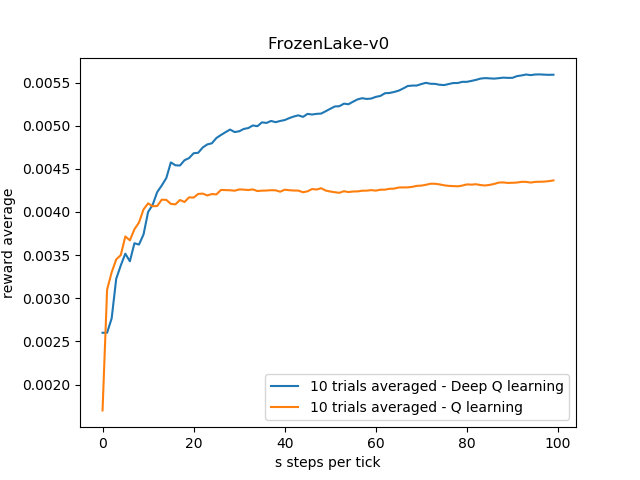

In [5]:
import gym
%matplotlib notebook
import matplotlib.pyplot as plt
from learners.q_learning import QLearning

s_trials = []
q_trials = []
env = gym.make('FrozenLake-v0')

for i in range(10):
    print(f'beginning trial {i + 1}')
    agentD = DeepQLearning()
    rewards = agentD.fit(env, steps = 100000)
    s_trials.append(rewards)
    
    agentQ = QLearning()
    action_values, rewards = agentQ.fit(env, steps = 100000)
    q_trials.append(rewards)

## plotting
plt.plot(np.average(s_trials[:10], axis=0), label='10 trials averaged - Deep Q learning')
plt.plot(np.average(q_trials[:10], axis=0), label='10 trials averaged - Q learning')
plt.title('FrozenLake-v0')
plt.xlabel('s steps per tick')
plt.ylabel('reward average')
plt.legend()
plt.show()

In [ ]:
# watch Q Learning agent play
states, actions, rewads = agentQ.predict(env, action_values)

In [ ]:
# watch Deep Q learning agent play
states, actions, rewads = agentD.predict(env)